# Classification modeling
---

# TODO:
- interpret AUC curves
- can you add CUTI index to the plots of misclassified data? curious about whether misclassifications are concentrated around CUTI values near 0.
- question whether this notebook is too long.... I could put the log reg models and decision tree models into their own notebooks but it might make model comparison more annoying

---

For my baseline model, I need to ask myself what I'm actually trying to do and whether my audience cares more about accuracy or interpretation. In academic settings and Earth sciences, I prefer to prioritize interpretation since I'm working with real-world concepts and I'd like to be able to use these methods to learn about the oceanographic processes at play here. For this reason, I'll be using scikit-learn's Logistic Regression model, a straightforward classification model that prioritizes interpretability over accuracy. There are several assumptions we make about our data when we use this model, including assuming that our independent variables are independent *of each other*. 

However, I know this isn't the case in my data and the variables are strongly correlated with each other. Out of curiosity, I'm going to make a model with each feature individually as one way to avoid the multicollinearity, and then use polynomial features to engineer some interaction features and utilize regularization techniques to reduce the effect of multicollinearity. 

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix, classification_report, plot_roc_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

random.seed(42)

---
### Load the data

In [21]:
df = pd.read_csv('../../coastal_upwelling_output/clean_dataframe.csv')

In [22]:
df

,time,density,practical_salinity,seawater_temperature,sea_surface_temperature,CUTI,upwelling,upwelling_multi
0,2017-01-01 00:00:00,1027.258767,33.916755,7.766451,11.273,1.731,1,1
1,2017-01-01 00:01:00,1027.260164,33.917475,7.760876,11.268,1.731,1,1
2,2017-01-01 00:02:00,1027.258920,33.917249,7.767207,11.267,1.731,1,1
3,2017-01-01 00:03:00,1027.258097,33.916964,7.771317,11.267,1.731,1,1
4,2017-01-01 00:04:00,1027.258173,33.917076,7.771017,11.278,1.731,1,1
...,...,...,...,...,...,...,...,...
329194,2017-09-15 23:55:00,1027.366397,33.960043,7.866675,15.198,-0.194,0,0
329195,2017-09-15 23:56:00,1027.366555,33.960125,7.866182,15.171,-0.194,0,0
329196,2017-09-15 23:57:00,1027.365319,33.959667,7.872284,15.158,-0.194,0,0
329197,2017-09-15 23:58:00,1027.364325,33.959192,7.876495,15.199,-0.194,0,0


This dataframe is over 300,000 observations, which I'm hesitant to pass to a model right away. I'm going to resample down to a small size at first, and then add data back in once the workflow is established.

In [23]:
df['time'] = pd.to_datetime(df['time'])

In [25]:
print(df['CUTI'].quantile(.35))
print(df['CUTI'].quantile(.65))

-0.116
0.367


In [26]:
# nested lambda conditionals source: https://stackoverflow.com/questions/44991438/lambda-including-if-elif-else
df['upwelling_multi'] = df['CUTI'].apply(lambda x: 1 if x > 0.367 else (-1 if x < -0.116 else 0))

In [27]:
df['upwelling_multi'].value_counts(normalize=True)

-1    0.349983
 1    0.349837
 0    0.300180
Name: upwelling_multi, dtype: float64

In [28]:
df_resampled = df.resample('20T', on='time').mean().dropna(how='all').reset_index().drop(columns=['CUTI', 'density'])
print(df_resampled.shape)

(17714, 6)


In [6]:
# indices_to_drop = df_resampled.loc[df_resampled['upwelling_multi'] == 0].index

In [7]:
# df_resampled = df_resampled.drop(index=indices_to_drop, axis=0).reset_index(drop=True)

In [29]:
df_resampled

,time,practical_salinity,seawater_temperature,sea_surface_temperature,upwelling,upwelling_multi
0,2017-01-01 00:00:00,33.917802,7.768099,11.27030,1.0,1.0
1,2017-01-01 00:20:00,33.923736,7.695256,11.26795,1.0,1.0
2,2017-01-01 00:40:00,33.925383,7.688413,11.26675,1.0,1.0
3,2017-01-01 01:00:00,33.926747,7.698557,11.26465,1.0,1.0
4,2017-01-01 01:20:00,33.916462,7.764130,11.26475,1.0,1.0
...,...,...,...,...,...,...
17709,2017-09-15 22:20:00,33.948736,8.005974,15.24465,0.0,-1.0
17710,2017-09-15 22:40:00,33.946218,8.028650,15.25365,0.0,-1.0
17711,2017-09-15 23:00:00,33.953680,7.949766,15.22895,0.0,-1.0
17712,2017-09-15 23:20:00,33.942572,8.052701,15.17020,0.0,-1.0


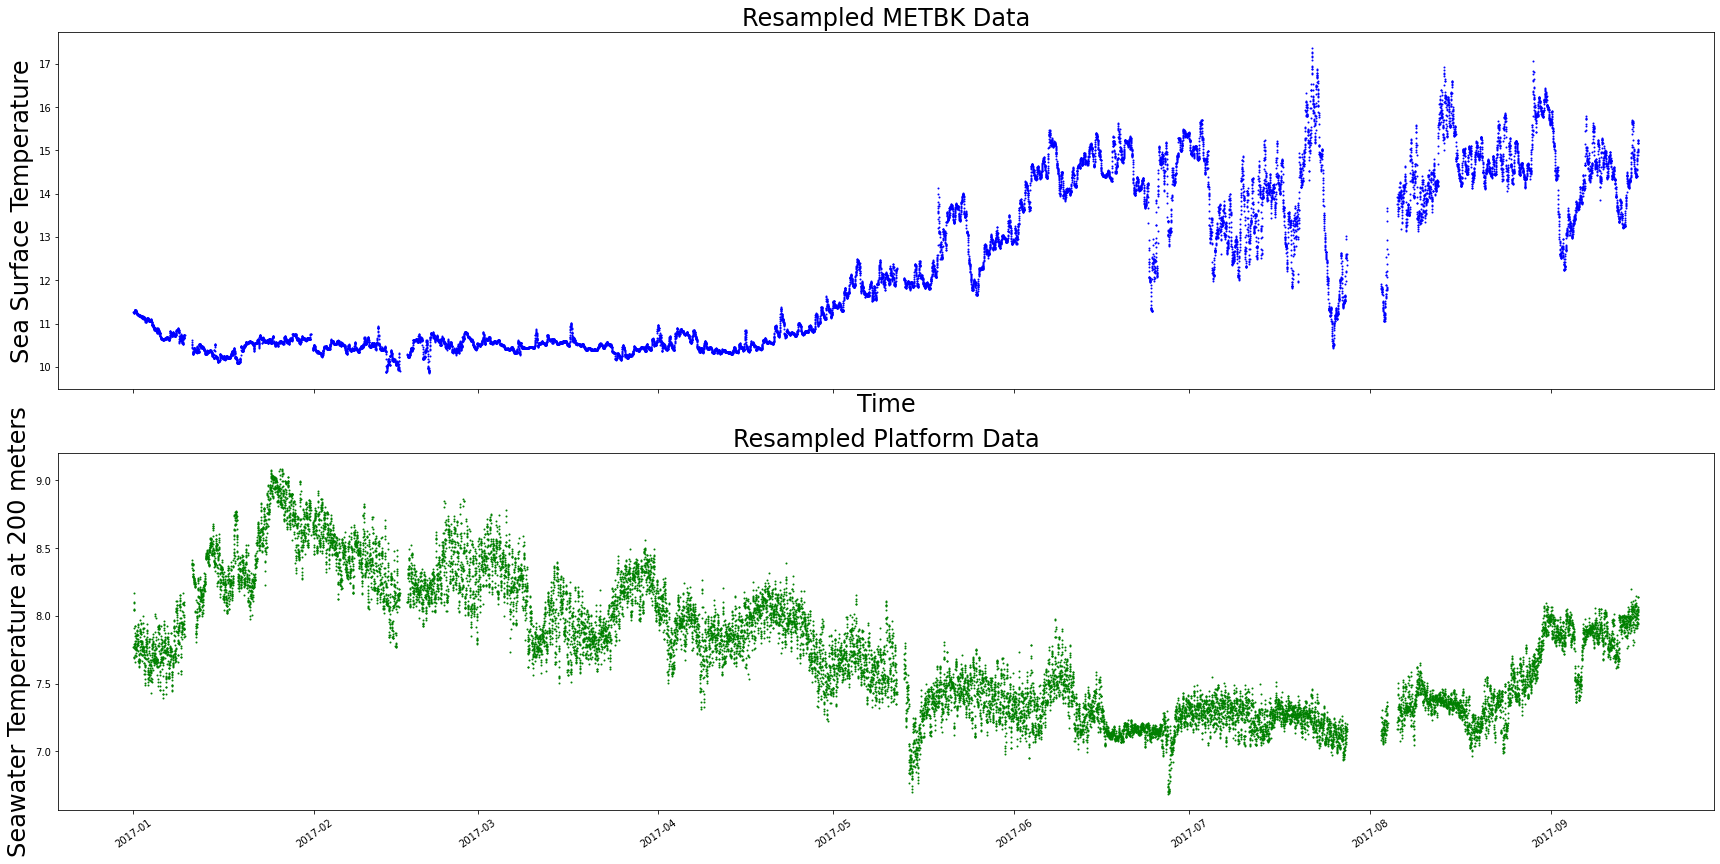

In [30]:
fig, (ax2, ax1) = plt.subplots(2,1, sharex=True, figsize = (24, 12)) 
ax1.scatter(x=df_resampled['time'], y=df_resampled['seawater_temperature'], c='g', s=1)
ax1.set_ylabel('Seawater Temperature at 200 meters', size=24)
ax1.set_title('Resampled Platform Data', size=24)

ax2.scatter(x=df_resampled['time'], y=df_resampled['sea_surface_temperature'], c='b', s=1)
ax2.set_xlabel('Time', size=24)
ax2.set_ylabel('Sea Surface Temperature', size=24)
ax2.set_title('Resampled METBK Data', size=24)

plt.xticks(rotation=35);
plt.tight_layout()

In [31]:
df_resampled

,time,practical_salinity,seawater_temperature,sea_surface_temperature,upwelling,upwelling_multi
0,2017-01-01 00:00:00,33.917802,7.768099,11.27030,1.0,1.0
1,2017-01-01 00:20:00,33.923736,7.695256,11.26795,1.0,1.0
2,2017-01-01 00:40:00,33.925383,7.688413,11.26675,1.0,1.0
3,2017-01-01 01:00:00,33.926747,7.698557,11.26465,1.0,1.0
4,2017-01-01 01:20:00,33.916462,7.764130,11.26475,1.0,1.0
...,...,...,...,...,...,...
17709,2017-09-15 22:20:00,33.948736,8.005974,15.24465,0.0,-1.0
17710,2017-09-15 22:40:00,33.946218,8.028650,15.25365,0.0,-1.0
17711,2017-09-15 23:00:00,33.953680,7.949766,15.22895,0.0,-1.0
17712,2017-09-15 23:20:00,33.942572,8.052701,15.17020,0.0,-1.0


---
### Checking feature correlation

One of the big assumptions we make when building logistic regression models is that our independent features are independent of each other. We can print out a heatmap to check whether our features are correlated to each other or not.

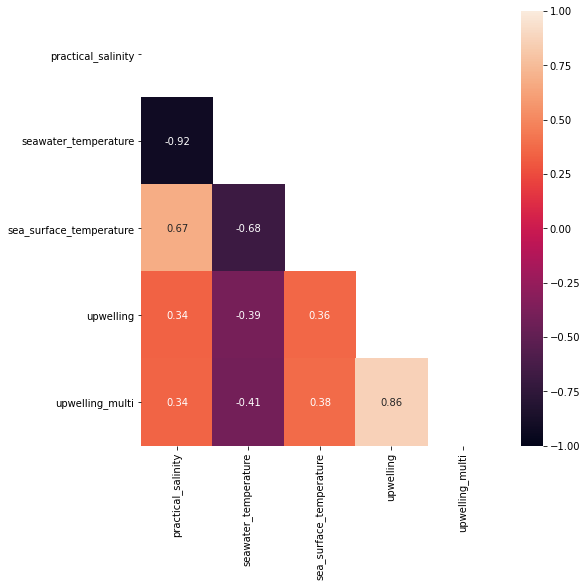

In [32]:
plt.figure(figsize=(8,8))

corr = df_resampled.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(df_resampled.corr(), annot=True, vmin=-1, vmax=1, mask=mask);

Yup, looks like our features are correlated with each other! We can also tell from this heatmap that seawater temperature collected by the 200 meter platform is most strongly correlated to upwelling of all our features. I'll build a logistic regression model without addressing the multicollinearity first, and then attempt to improve it by using PolynomialFeatures and ridge and lasso penalties. 

c:\users\derya\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\derya\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


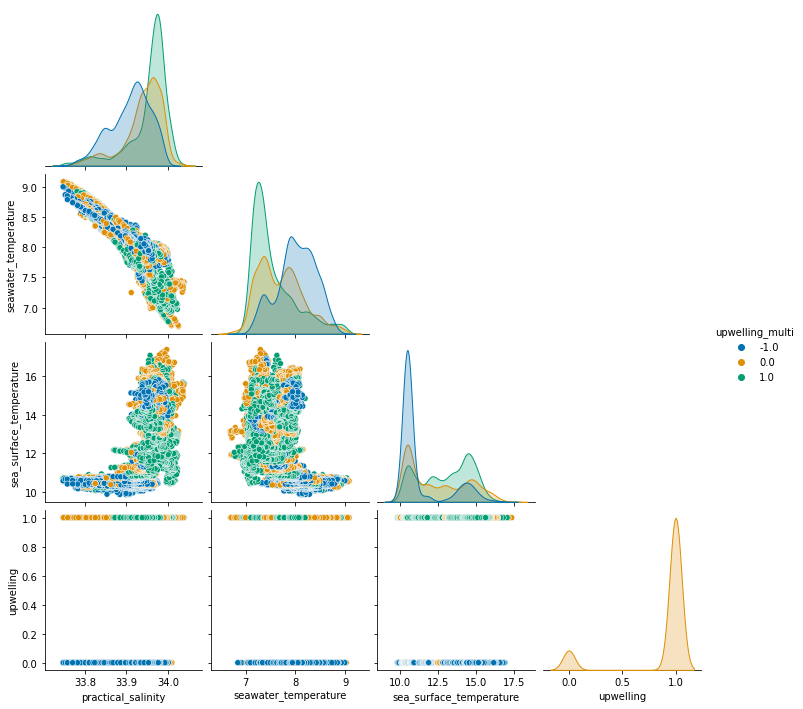

In [33]:
sns.pairplot(df_resampled, corner=True, hue='upwelling_multi', palette='colorblind');

---
## Logistic regression classifiers

### Using only one feature

This sections is on building a model with only seawater temperature from the 200 meter platform as the prediction.

In [47]:
X = df_resampled['seawater_temperature']
y = df_resampled['upwelling_multi']

y.value_counts(normalize=True)

 1.0    0.355538
-1.0    0.346675
 0.0    0.297787
Name: upwelling_multi, dtype: float64

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

Create a pipeline with StandardScaler and LogisticRegression

In [49]:
pipe = Pipeline([
    ('sc', StandardScaler()),
    ('logreg', LogisticRegression(multi_class='ovr', solver='liblinear'))
])

In [50]:
pipe.fit(X_train.values.reshape(-1, 1), y_train)

Pipeline(steps=[('sc', StandardScaler()),
                ('logreg',
                 LogisticRegression(multi_class='ovr', solver='liblinear'))])

In [51]:
print(f'Train accuracy: {pipe.score(X_train.values.reshape(-1, 1), y_train)}')
print(f'Test accuracy: {pipe.score(X_test.values.reshape(-1, 1), y_test)}')

Train accuracy: 0.5331576966503575
Test accuracy: 0.5204335064348612


In [52]:
print(cross_val_score(pipe, X_train.values.reshape(-1, 1), y_train).mean())
print(cross_val_score(pipe, X_test.values.reshape(-1, 1), y_test).mean())

0.5332329695144901
0.5188476106668708


In [53]:
logreg = pipe.named_steps['logreg']
print(f'LogReg Intercept: {logreg.intercept_}')
print(f'LogReg Coef: {logreg.coef_}')

LogReg Intercept: [-0.73723199 -0.86199121 -0.69148252]
LogReg Coef: [[ 0.91560138]
 [-0.14693721]
 [-0.79945835]]


This model performs better than our baseline, woohoo! But maybe we can do better with polynomial features.

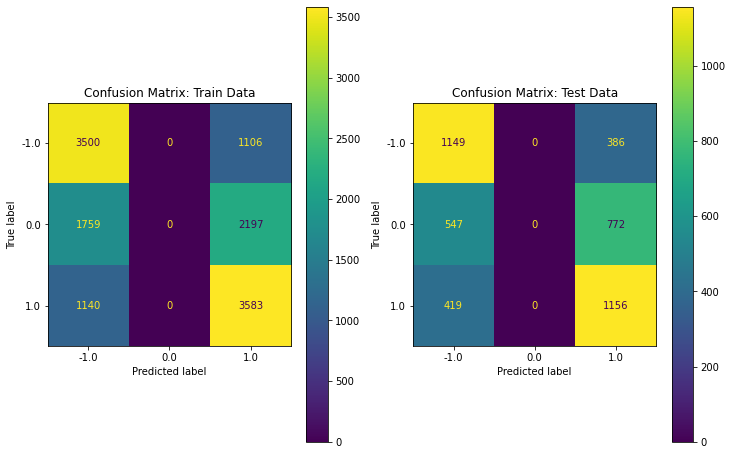

In [54]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

plot_confusion_matrix(pipe, X_train.values.reshape(-1, 1), y_train, ax=ax1)
ax1.set_title('Confusion Matrix: Train Data')

plot_confusion_matrix(pipe, X_test.values.reshape(-1, 1), y_test, ax=ax2)
ax2.set_title('Confusion Matrix: Test Data');

In [55]:
test_preds = pipe.predict(X_test.values.reshape(-1, 1))
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

        -1.0       0.54      0.75      0.63      1535
         0.0       0.00      0.00      0.00      1319
         1.0       0.50      0.73      0.59      1575

    accuracy                           0.52      4429
   macro avg       0.35      0.49      0.41      4429
weighted avg       0.37      0.52      0.43      4429



c:\users\derya\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\derya\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\derya\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [56]:
# ROC curve
plot_roc_curve(logreg, X_test.values.reshape(-1, 1), y_test)

# add worst case scenario line
plt.plot([0,1],[0,1], label='baseline', linestyle='--')

# add a legend
plt.legend();
# want AUC (area under curve) to be as close to 1 as possible

ValueError: LogisticRegression should be a binary classifier

---
### Using PolynomialFeatures

Now let's add those features back in and use feature interactions combined with regularization to try upping the accuracy while accounting for the multicollinearity.

An easy way to get a variety of feature interactions is using sklearn's PolynomialFeatures function. There are four features in this model, so I'll set the degree to 4 so that there will be an engineered feature that includes all 4 of the original features. 

In [57]:
X = df_resampled.drop(columns=['upwelling', 'upwelling_multi', 'time'])
y = df_resampled['upwelling_multi']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [59]:
pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)),
    ('sc', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, multi_class='ovr', solver='liblinear'))
])

pipe_params = {
    'logreg__penalty':['l1', 'l2'],
    'logreg__C': np.linspace(0.001, 1, 10)
}

gs_lr = GridSearchCV(pipe, pipe_params, cv=5, verbose=1, return_train_score=True)

gs_lr.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly',
                                        PolynomialFeatures(include_bias=False)),
                                       ('sc', StandardScaler()),
                                       ('logreg',
                                        LogisticRegression(max_iter=1000,
                                                           multi_class='ovr',
                                                           solver='liblinear'))]),
             param_grid={'logreg__C': array([0.001, 0.112, 0.223, 0.334, 0.445, 0.556, 0.667, 0.778, 0.889,
       1.   ]),
                         'logreg__penalty': ['l1', 'l2']},
             return_train_score=True, verbose=1)

In [60]:
print(f'Best parameters: {gs_lr.best_params_}')
print(f'Best score: {gs_lr.best_score_}')

Best parameters: {'logreg__C': 1.0, 'logreg__penalty': 'l1'}
Best score: 0.5597290176891231


Now that we have the best parameters, we can create a logistic regression model with these parameters and see what the coefficients are for our poly features.

In [61]:
print(gs_lr.cv_results_['mean_train_score'].mean())
print(gs_lr.cv_results_['mean_test_score'].mean())

0.5507367331576967
0.5500790365073392


In [62]:
print(f'Train accuracy: {gs_lr.score(X_train, y_train)}')
print(f'Test accuracy: {gs_lr.score(X_test, y_test)}')

Train accuracy: 0.5610839292435077
Test accuracy: 0.5527207044479566


Question to self: do the coefficients need to be exponentiated to get their actual values, since the logistic regression model uses the logit function to transform the data?

In [63]:
gs_lr.predict(X_train)

array([-1., -1.,  1., ...,  1.,  1., -1.])

In [64]:
gs_lr.best_estimator_['logreg'].coef_

array([[ 0.00000000e+00,  8.57718596e+00,  0.00000000e+00,
        -3.64937559e-01,  1.22106303e+01,  0.00000000e+00,
        -1.86419431e+01, -3.45912574e+00,  4.12887928e+00],
       [ 0.00000000e+00, -4.36909541e-01, -2.34986468e+00,
        -1.77052731e-02, -4.36416756e-01, -2.73649764e+00,
        -1.80541460e-01,  1.61646551e+00,  2.98624287e+00],
       [ 0.00000000e+00, -4.54585915e+00,  2.41926421e+00,
         1.27670080e-01, -8.84496642e+00,  3.70687036e+00,
         1.22565644e+01,  2.13088997e+00, -8.28413218e+00]])

In [65]:
poly_features = gs_lr.estimator.named_steps['poly'].fit(X_train).get_feature_names(X.columns)
coefs = gs_lr.best_estimator_['logreg'].coef_[0]

In [66]:
sorted(list(zip(poly_features, coefs)), key=lambda x: x[1])[:10]

[('seawater_temperature^2', -18.641943097782363),
 ('seawater_temperature sea_surface_temperature', -3.459125741288125),
 ('practical_salinity^2', -0.364937558809349),
 ('practical_salinity', 0.0),
 ('sea_surface_temperature', 0.0),
 ('practical_salinity sea_surface_temperature', 0.0),
 ('sea_surface_temperature^2', 4.1288792754635),
 ('seawater_temperature', 8.57718596489335),
 ('practical_salinity seawater_temperature', 12.210630274747714)]

In [67]:
sorted(list(zip(poly_features, coefs)), key=lambda x: x[1])[-10:]

[('seawater_temperature^2', -18.641943097782363),
 ('seawater_temperature sea_surface_temperature', -3.459125741288125),
 ('practical_salinity^2', -0.364937558809349),
 ('practical_salinity', 0.0),
 ('sea_surface_temperature', 0.0),
 ('practical_salinity sea_surface_temperature', 0.0),
 ('sea_surface_temperature^2', 4.1288792754635),
 ('seawater_temperature', 8.57718596489335),
 ('practical_salinity seawater_temperature', 12.210630274747714)]

In [68]:
gs_lr_train_preds = gs_lr.predict(X_train)
gs_lr_test_preds = gs_lr.predict(X_test)

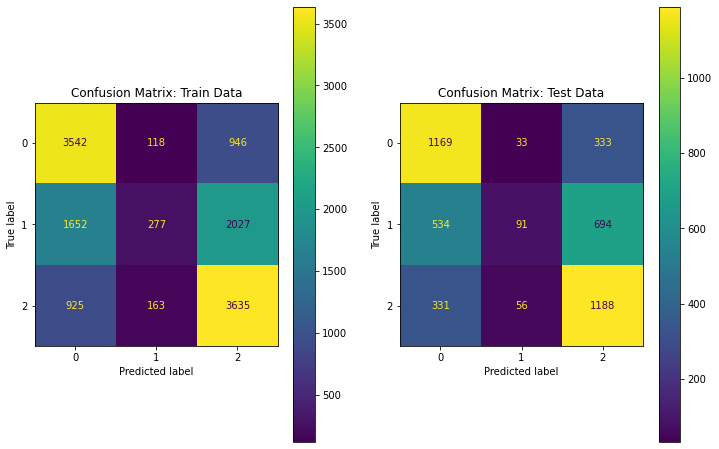

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

cm = confusion_matrix(y_train, gs_lr_train_preds)
ConfusionMatrixDisplay(cm).plot(ax=ax1)
ax1.set_title('Confusion Matrix: Train Data')

cm = confusion_matrix(y_test, gs_lr_test_preds)
ConfusionMatrixDisplay(cm).plot(ax=ax2)
ax2.set_title('Confusion Matrix: Test Data');

Looks like our false negatives outnumber our false positives

In [70]:
print(classification_report(y_test, gs_lr_test_preds))

              precision    recall  f1-score   support

        -1.0       0.57      0.76      0.66      1535
         0.0       0.51      0.07      0.12      1319
         1.0       0.54      0.75      0.63      1575

    accuracy                           0.55      4429
   macro avg       0.54      0.53      0.47      4429
weighted avg       0.54      0.55      0.49      4429



In [71]:
# ROC curve
plot_roc_curve(gs_lr, X_test, y_test)

# add worst case scenario line
plt.plot([0,1],[0,1], label='baseline', linestyle='--')

# add a legend
plt.legend();
# want AUC (area under curve) to be as close to 1 as possible

ValueError: GridSearchCV should be a binary classifier

#### Explore misclassified data

In [72]:
# Get indices of misclassified data source: https://stackoverflow.com/questions/25551977/retrieve-misclassified-documents-using-scikitlearn
misclass_ind_lr = np.where(y_test != gs_lr_test_preds)
misclass_ind_lr

(array([   3,    5,    8, ..., 4422, 4424, 4427], dtype=int64),)

In [73]:
X_test

,practical_salinity,seawater_temperature,sea_surface_temperature
3135,33.904433,8.136546,9.974972
10911,33.951738,7.450618,14.756700
15833,33.994250,7.310137,14.554118
5396,33.914999,7.884333,10.435150
16682,33.963177,7.857342,14.807029
...,...,...,...
9567,33.964671,7.360591,12.259100
9783,33.947663,7.505483,13.732700
5821,33.910244,8.230455,10.464794
12321,33.987449,7.145161,12.087235


In [74]:
df_resampled

,time,practical_salinity,seawater_temperature,sea_surface_temperature,upwelling,upwelling_multi
0,2017-01-01 00:00:00,33.917802,7.768099,11.27030,1.0,1.0
1,2017-01-01 00:20:00,33.923736,7.695256,11.26795,1.0,1.0
2,2017-01-01 00:40:00,33.925383,7.688413,11.26675,1.0,1.0
3,2017-01-01 01:00:00,33.926747,7.698557,11.26465,1.0,1.0
4,2017-01-01 01:20:00,33.916462,7.764130,11.26475,1.0,1.0
...,...,...,...,...,...,...
17709,2017-09-15 22:20:00,33.948736,8.005974,15.24465,0.0,-1.0
17710,2017-09-15 22:40:00,33.946218,8.028650,15.25365,0.0,-1.0
17711,2017-09-15 23:00:00,33.953680,7.949766,15.22895,0.0,-1.0
17712,2017-09-15 23:20:00,33.942572,8.052701,15.17020,0.0,-1.0


In [75]:
df_resampled.iloc[X_test.index]['time']

3135    2017-02-15 08:20:00
10911   2017-06-05 22:20:00
15833   2017-08-20 21:00:00
5396    2017-03-20 02:00:00
16682   2017-09-01 16:00:00
                ...        
9567    2017-05-18 06:20:00
9783    2017-05-21 06:20:00
5821    2017-03-25 23:40:00
12321   2017-06-25 12:20:00
10005   2017-05-24 08:20:00
Name: time, Length: 4429, dtype: datetime64[ns]

In [76]:
X_test_times = df_resampled.iloc[X_test.index]['time']

In [77]:
X_test_times.iloc[misclass_ind_lr]

5396    2017-03-20 02:00:00
12285   2017-06-25 00:20:00
15291   2017-08-13 08:20:00
8326    2017-04-29 18:40:00
2211    2017-02-02 12:20:00
                ...        
14086   2017-07-20 00:40:00
6777    2017-04-08 06:20:00
2958    2017-02-12 21:20:00
9567    2017-05-18 06:20:00
12321   2017-06-25 12:20:00
Name: time, Length: 1981, dtype: datetime64[ns]

In [78]:
pd.DataFrame(X_test_times.iloc[misclass_ind_lr]).reset_index(drop=True)

,time
0,2017-03-20 02:00:00
1,2017-06-25 00:20:00
2,2017-08-13 08:20:00
3,2017-04-29 18:40:00
4,2017-02-02 12:20:00
...,...
1976,2017-07-20 00:40:00
1977,2017-04-08 06:20:00
1978,2017-02-12 21:20:00
1979,2017-05-18 06:20:00


In [79]:
frames_lr = [pd.DataFrame(X_test_times.iloc[misclass_ind_lr]), X_test.iloc[misclass_ind_lr], pd.DataFrame(y_test.iloc[misclass_ind_lr])]
misclass_df_lr = pd.concat(frames_lr, axis=1)

In [80]:
misclass_df_lr

,time,practical_salinity,seawater_temperature,sea_surface_temperature,upwelling_multi
5396,2017-03-20 02:00:00,33.914999,7.884333,10.435150,0.0
12285,2017-06-25 00:20:00,33.984949,7.139434,12.488323,0.0
15291,2017-08-13 08:20:00,33.964777,7.371131,15.841200,-1.0
8326,2017-04-29 18:40:00,33.960295,7.463281,11.633588,0.0
2211,2017-02-02 12:20:00,33.842592,8.605779,10.363235,0.0
...,...,...,...,...,...
14086,2017-07-20 00:40:00,33.974155,7.318704,14.474550,0.0
6777,2017-04-08 06:20:00,33.966561,7.459916,10.422382,-1.0
2958,2017-02-12 21:20:00,33.917486,8.021880,10.412500,1.0
9567,2017-05-18 06:20:00,33.964671,7.360591,12.259100,0.0


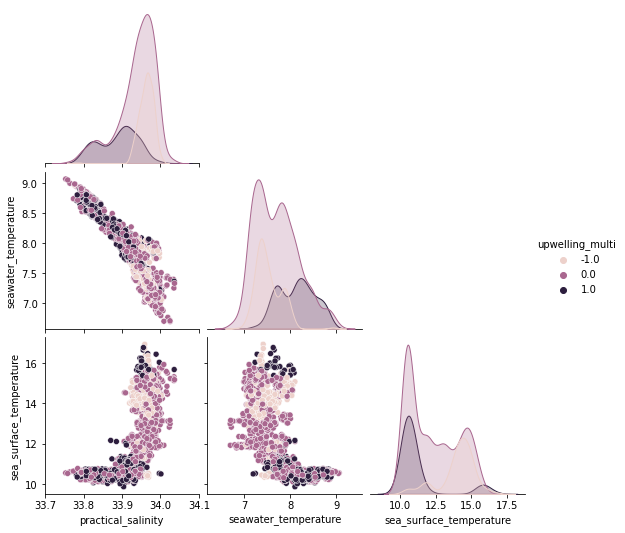

In [81]:
sns.pairplot(misclass_df_lr, corner=True, hue='upwelling_multi');

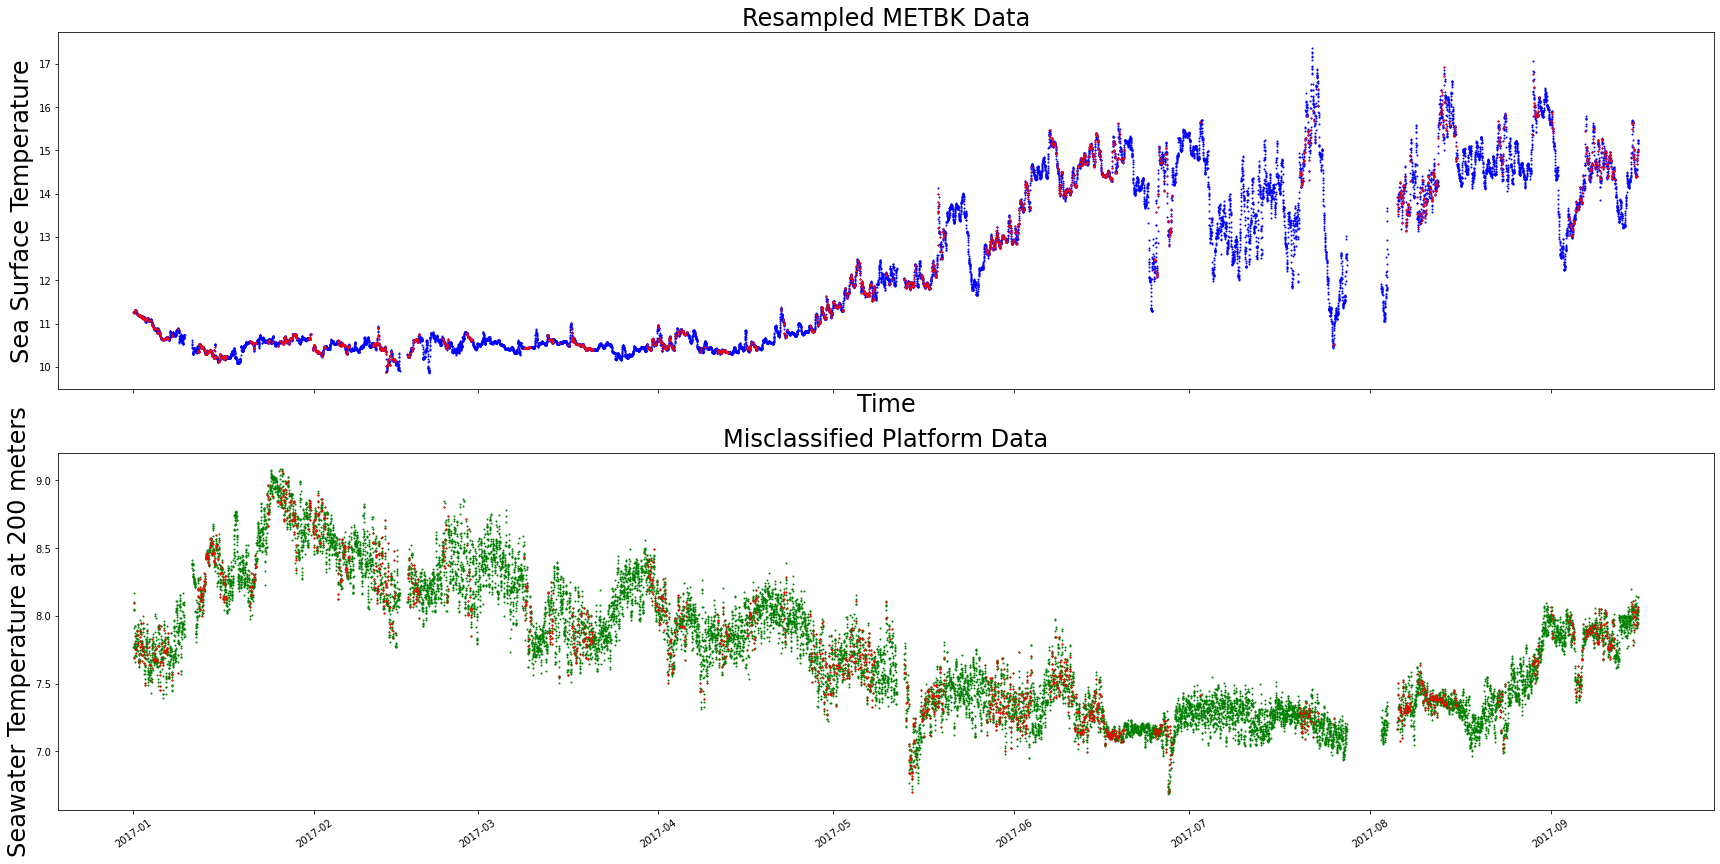

In [82]:
fig, (ax2, ax1) = plt.subplots(2,1, sharex=True, figsize = (24, 12)) 
ax1.scatter(x=df_resampled['time'], y=df_resampled['seawater_temperature'], c='g', s=1)
ax1.set_ylabel('Seawater Temperature at 200 meters', size=24)
ax1.set_title('Misclassified Platform Data', size=24)

ax1.scatter(x=misclass_df_lr['time'], y=misclass_df_lr['seawater_temperature'], c='r', s=1)

ax2.scatter(x=df_resampled['time'], y=df_resampled['sea_surface_temperature'], c='b', s=1)
ax2.set_xlabel('Time', size=24)
ax2.set_ylabel('Sea Surface Temperature', size=24)
ax2.set_title('Resampled METBK Data', size=24)

ax2.scatter(x=misclass_df_lr['time'], y=misclass_df_lr['sea_surface_temperature'], c='r', s=1)



plt.xticks(rotation=35);
plt.tight_layout()

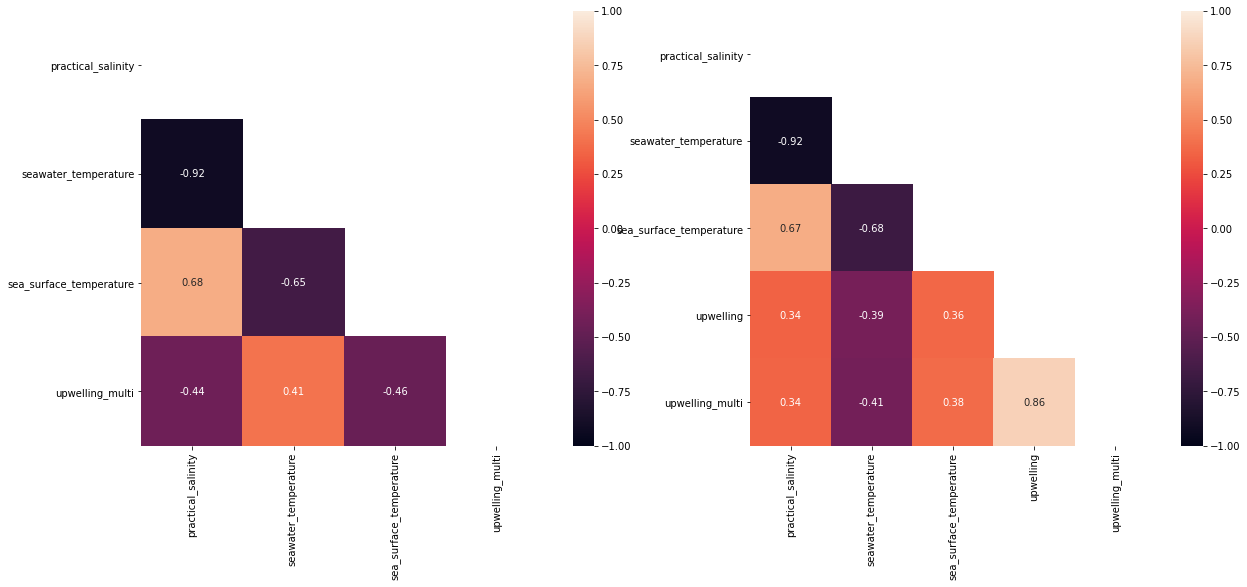

In [83]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))

corr = misclass_df_lr.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(misclass_df_lr.corr(), annot=True, vmin=-1, vmax=1, mask=mask, ax=ax1)

corr = df_resampled.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(df_resampled.corr(), annot=True, vmin=-1, vmax=1, mask=mask, ax=ax2);

---
### Decision tree classifiers
Decision trees come in a lot of different shapes, so it'd be best to use GridSearchCV to find the best parameters for a tree for upwelling classification.

In [84]:
X = df_resampled.drop(columns=['time', 'upwelling', 'upwelling_multi'])
y = df_resampled['upwelling_multi']

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [86]:
param_grid = {
    'max_depth': [5, 7, 9],
    'min_samples_split': [5, 10, 15, 20],
    'min_samples_leaf': [2, 3, 4, 5, 6],
    'ccp_alpha': [0, 0.01, 0.1, 1, 10]
}

gs_dt = GridSearchCV(estimator=DecisionTreeClassifier(),
                 param_grid=param_grid,
                 verbose=1,
                 cv=5)

%time gs_dt.fit(X_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Wall time: 34.2 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': [0, 0.01, 0.1, 1, 10],
                         'max_depth': [5, 7, 9],
                         'min_samples_leaf': [2, 3, 4, 5, 6],
                         'min_samples_split': [5, 10, 15, 20]},
             verbose=1)

In [87]:
gs_dt.best_estimator_

DecisionTreeClassifier(ccp_alpha=0, max_depth=9, min_samples_leaf=5,
                       min_samples_split=10)

In [88]:
print(f'Score on training set: {gs_dt.score(X_train, y_train)}')
print(f'Score on testing set: {gs_dt.score(X_test, y_test)}')

Score on training set: 0.7083929243507715
Score on testing set: 0.6423571912395575


In [89]:
gs_dt_train_preds = gs_dt.predict(X_train)
gs_dt_test_preds = gs_dt.predict(X_test)

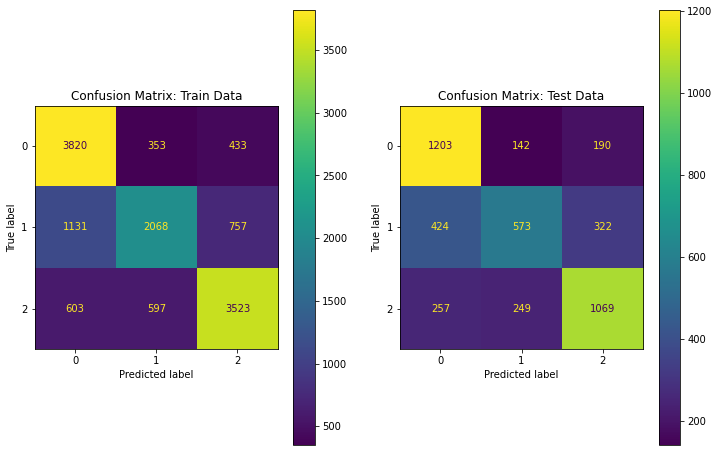

In [90]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

cm = confusion_matrix(y_train, gs_dt_train_preds)
ConfusionMatrixDisplay(cm).plot(ax=ax1)
ax1.set_title('Confusion Matrix: Train Data')

cm = confusion_matrix(y_test, gs_dt_test_preds)
ConfusionMatrixDisplay(cm).plot(ax=ax2)
ax2.set_title('Confusion Matrix: Test Data');

In [91]:
print(gs_dt.best_estimator_.feature_importances_)
list(X_train.columns)

[0.19183451 0.21009798 0.59806751]


['practical_salinity', 'seawater_temperature', 'sea_surface_temperature']

We saw that `seawater_temperature` was the most strongly correlated feature to upwelling, but `sea_surface_temperature` ended up having the greatest feature importance. I want to trust the model on this, but I'm wondering why this happened. 

IndexError: list index out of range

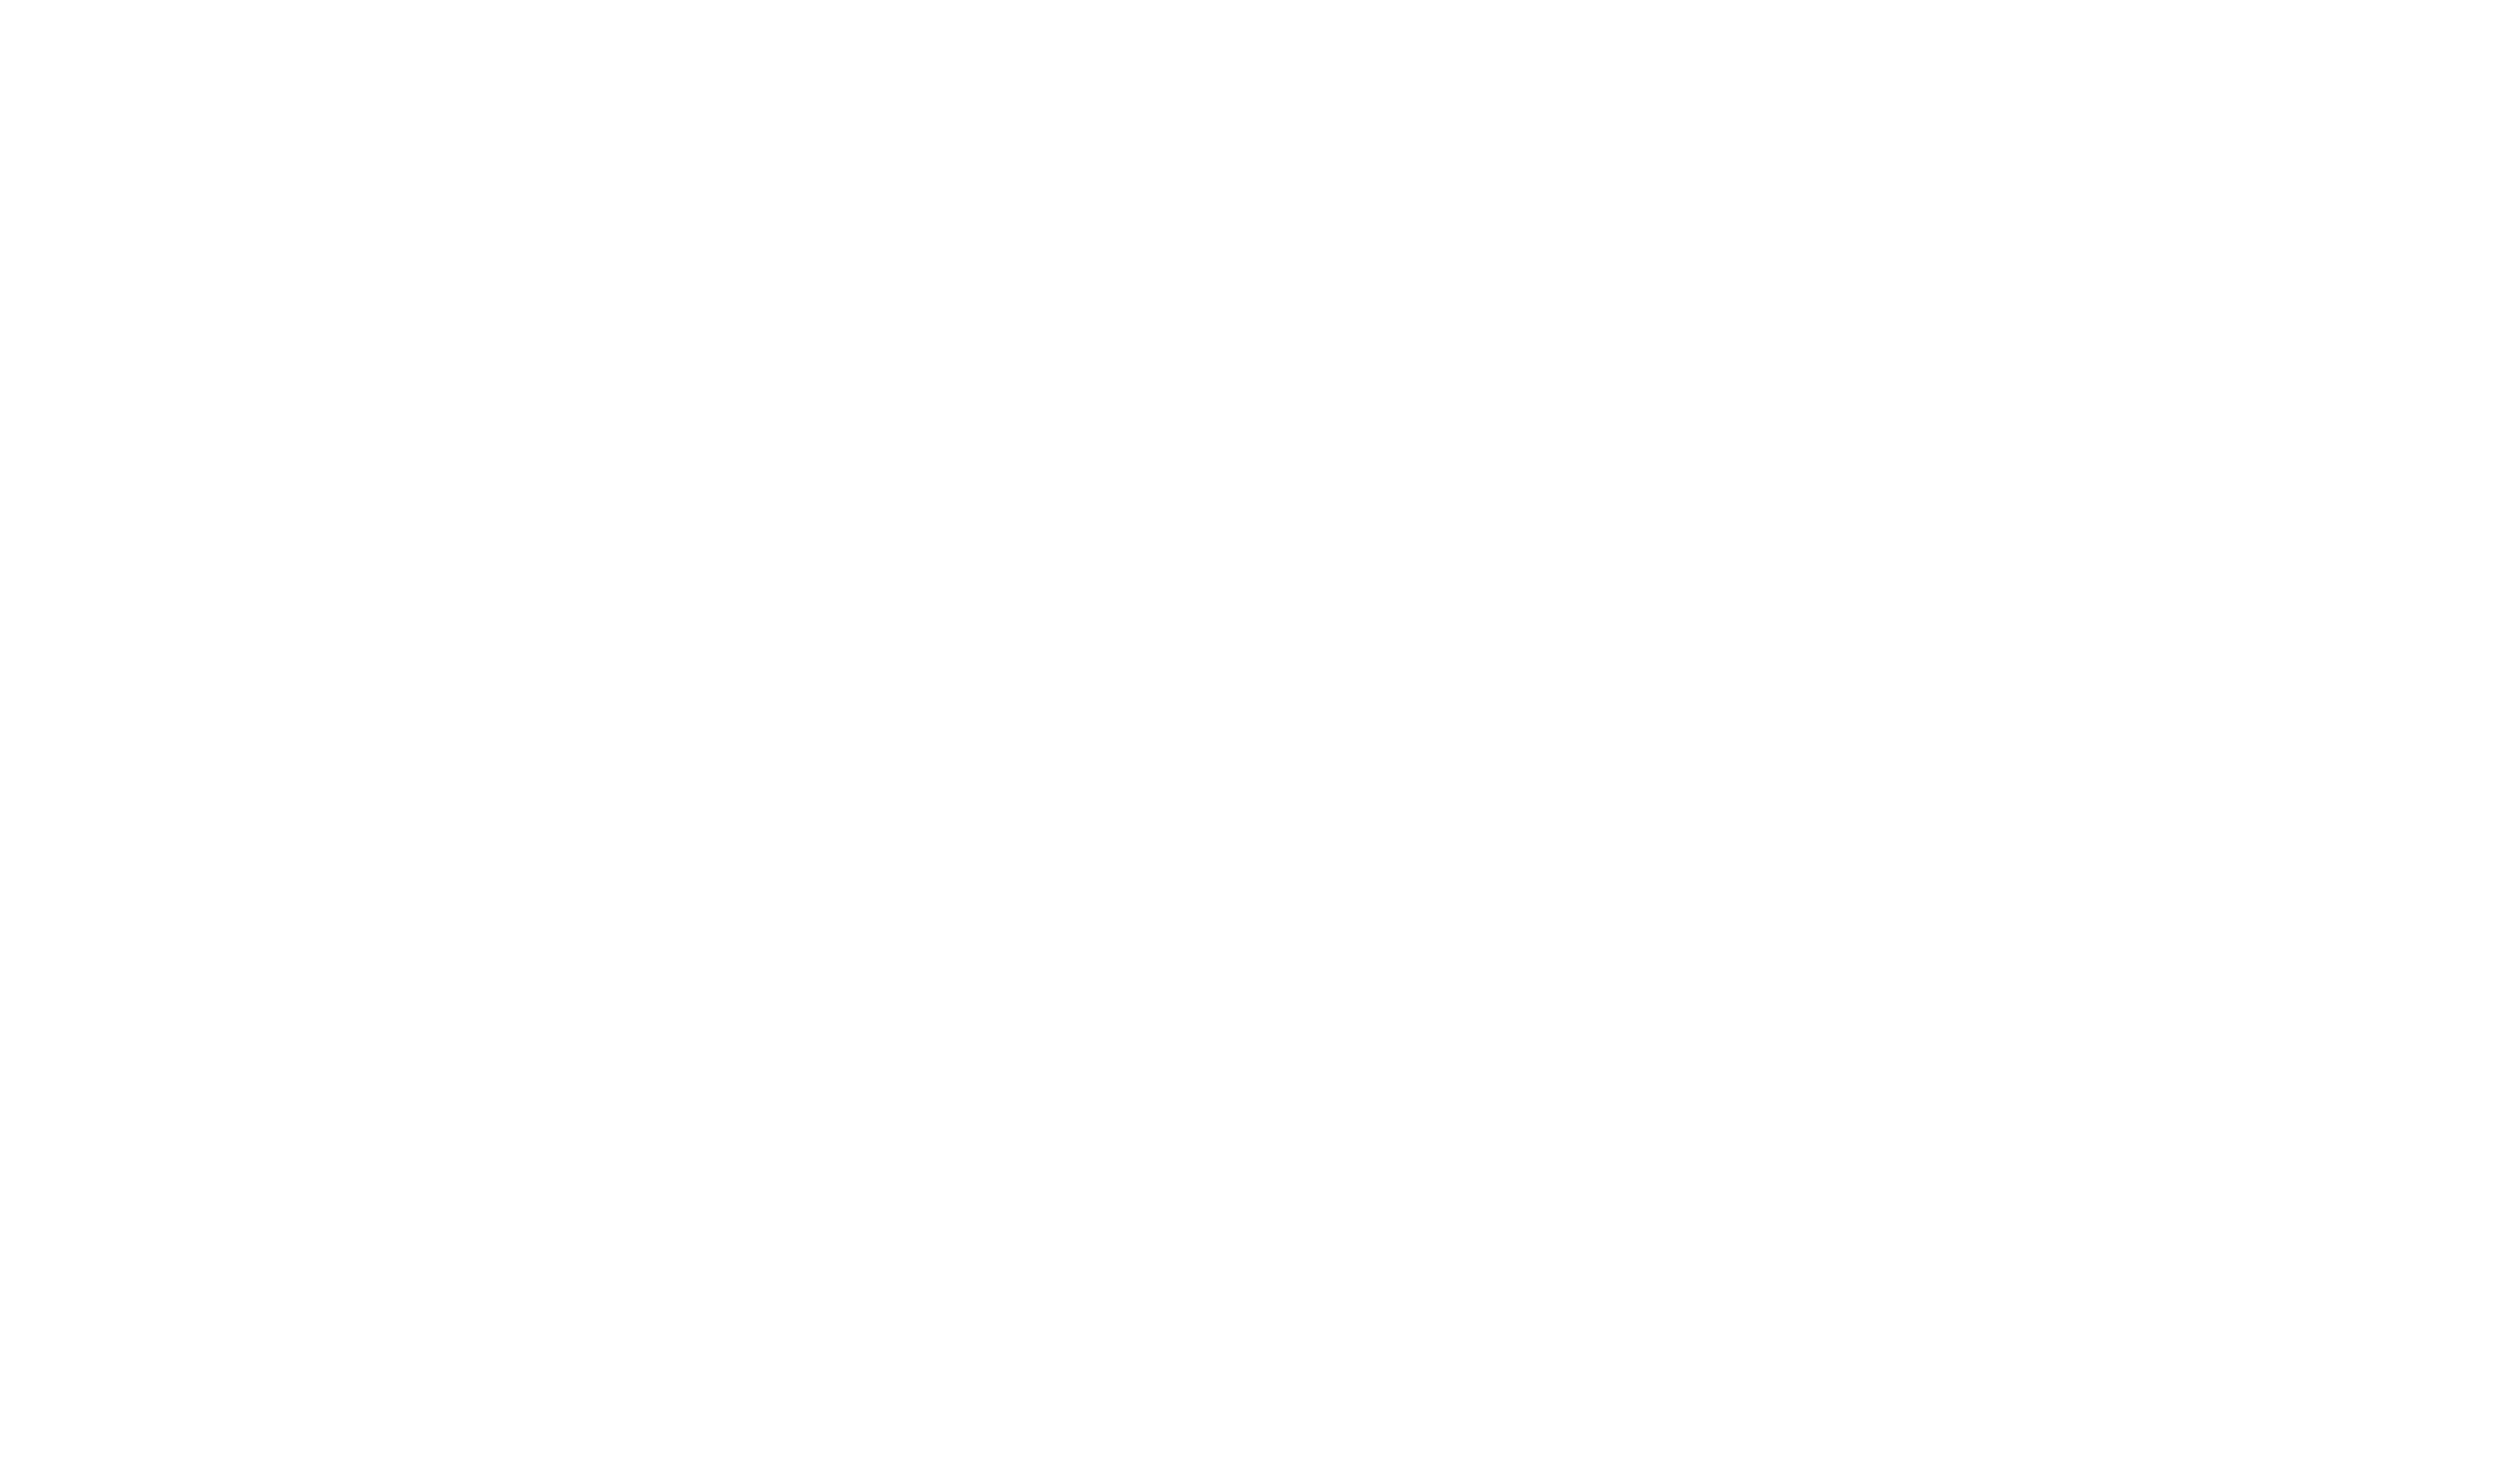

In [92]:
# Establish size of figure.
plt.figure(figsize = (50, 30))

# Plot our tree.
plot_tree(gs_dt.best_estimator_,
          feature_names = X_train.columns,
          class_names = ['Not upwelling', 'Upwelling'],
          filled = True);

In [ ]:
print(export_text(gs_dt.best_estimator_,
                  list(X_train.columns)));

In [ ]:
print(classification_report(y_test, gs_dt.predict(X_test)))

ValueError: GridSearchCV should be a binary classifier

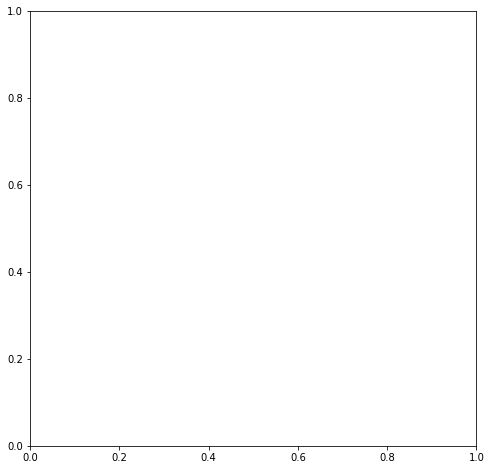

In [93]:
# ROC curve
fig, ax = plt.subplots(figsize=(8,8))

plot_roc_curve(gs_dt, X_test, y_test, ax=ax, name='Decision Tree')
plot_roc_curve(gs_lr, X_test, y_test, ax=ax, name='Logistic Regression')

# add worst case scenario line
plt.plot([0,1],[0,1], label='baseline', linestyle='--')

# add a legend
plt.legend();
# want AUC (area under curve) to be as close to 1 as possible

Interpretation goes here

#### Explore misclassified data

In [ ]:
# Get indices of misclassified data
misclass_ind_dt = np.where(y_test != gs_dt_test_preds)
# misclass_ind_dt

In [ ]:
X_test_times = df_resampled.iloc[X_test.index]['time']

In [ ]:
X_test_times.iloc[misclass_ind_dt]

In [ ]:
pd.DataFrame(X_test_times.iloc[misclass_ind_dt]).reset_index(drop=True)

In [ ]:
frames_dt = [pd.DataFrame(X_test_times.iloc[misclass_ind_dt]), X_test.iloc[misclass_ind_dt], pd.DataFrame(y_test.iloc[misclass_ind_dt])]
misclass_df_dt = pd.concat(frames_dt, axis=1)

In [ ]:
misclass_df_dt

In [ ]:
sns.pairplot(misclass_df_dt, corner=True, hue='upwelling_multi');

In [ ]:
df_resampled['CUTI'] = df['CUTI']

df['CUTI']

In [ ]:
sns.set_style('whitegrid')

In [ ]:
fig, (ax2, ax1) = plt.subplots(2,1, sharex=True, figsize = (24, 12)) 
ax1.scatter(x=df_resampled['time'], y=df_resampled['seawater_temperature'], c='g', s=1, label='Data')
ax1.set_ylabel('Seawater Temperature at 200 meters', size=24)
ax1.set_title('Misclassified Platform Data', size=24)

ax1.scatter(x=misclass_df_lr['time'], y=misclass_df_lr['seawater_temperature'], c='r', s=1, label='Log Reg Misclassified')
ax1.scatter(x=misclass_df_dt['time'], y=misclass_df_dt['seawater_temperature'], c='b', s=1, label='Decision Tree Misclassified')

ax2.scatter(x=df_resampled['time'], y=df_resampled['sea_surface_temperature'], c='g', s=1, label='Data')
ax2.set_xlabel('Time', size=24)
ax2.set_ylabel('Sea Surface Temperature', size=24)
ax2.set_title('Misclassified METBK Data', size=24)

ax2.scatter(x=misclass_df_lr['time'], y=misclass_df_lr['sea_surface_temperature'], c='r', s=1, label='Log Reg Misclassified')
ax2.scatter(x=misclass_df_dt['time'], y=misclass_df_dt['sea_surface_temperature'], c='b', s=1, label='Decision Tree Misclassified')

ax2.legend(fontsize=16, scatterpoints=40)
ax1.legend(fontsize=16, scatterpoints=40)
plt.xticks(rotation=35);
plt.tight_layout()
plt.savefig('../figures/misclassified_data.png')

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))

corr = misclass_df_dt.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(misclass_df_dt.corr(), annot=True, vmin=-1, vmax=1, mask=mask, ax=ax1)

corr = df_resampled.drop(columns='CUTI').corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(df_resampled.drop(columns='CUTI').corr(), annot=True, vmin=-1, vmax=1, mask=mask, ax=ax2);